# Task 2: Linear traffic shifting

Linear traffic shifting follows the blue/green deployment option where the original model is hosted in a blue fleet of instances and the new model is hosted in a green fleet of instances. When you shift traffic, you can choose either the number of instances or the percentage of the green fleet's capacity to activate during each step. 

As soon as SageMaker provisions the new fleet, the first portion of the green fleet turns on and receives traffic. SageMaker deactivates the same size portion of the blue fleet, and the baking period begins. If any alarms trip, all of the endpoint traffic is automatically rolled back to the blue fleet. If the baking period finishes, then the next step begins. Another portion of the green fleet activates and receives traffic, part of the blue fleet deactivates, and another baking period begins. The process repeats until the blue fleet is fully deactivated and the green fleet is fully activated and receiving all traffic. If an alarm goes off at any point, SageMaker terminates the shifting process and automatically rolls back 100 percent of the traffic to a reactivated blue fleet.

## Task 2.1: Environment setup

In this task, you will set up your environment, import any missing libraries, and create session variables.

In [1]:
%%capture
%matplotlib inline
from datetime import datetime, timedelta
import re
import json
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.image_uris import retrieve
from sagemaker.session import production_variant
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import boto3
import time
import os
import numpy as np
import pandas as pd

With the boto3 library imported, you can now create the session variables that you use throughout the lab.

In [2]:
#create-session-variables
region = boto3.Session().region_name
role = get_execution_role()
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")
cw = boto3.Session().client("cloudwatch")

bucket = sm_session.default_bucket()
prefix = 'sagemaker/abalone'

## Task 2.2: Create an endpoint

Create an endpoint with the production model you tested with the A/B and Shadow testing strategies. This endpoint is configured with the model that is currently in production. Later in the notebook, you update the endpoint configuration and use a deployment configuration to shift traffic to the new model.

To simulate the blue/green deployment, three endpoint configurations are created. The first endpoint configuration uses the production model. The second endpoint configuration uses the new model, which includes the wrong version of XGBoost, to simulate an issue in production. You use this model to explore how a blue/green deployment can roll back if it has an issue. The third endpoint configuration uses the new model with the correct configuration. The deployment configuration shifts traffic between fleets of instances, so five instances are configured for each model in the endpoint configurations.

<i class="fas fa-sticky-note" style="color:#ff6633"></i> **Note:** The endpoint creation takes approximately 4–6 minutes to complete.

In [3]:
#create-an-endpoint

# Upload models
model_url = S3Uploader.upload(
    local_path="models/model_A.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_error_url = S3Uploader.upload(
    local_path="models/model_E.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_new_url = S3Uploader.upload(
    local_path="models/model_B.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)

# Create the model definitions
model_1_name = f"abalone-A-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_2_name = f"abalone-Error-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_3_name = f"abalone-B-{datetime.now():%Y-%m-%d-%H-%M-%S}"

image_1_uri = retrieve("xgboost", boto3.Session().region_name, "1.5-1")
image_2_uri = retrieve("xgboost", boto3.Session().region_name, "1.2-1")
image_3_uri = retrieve("xgboost", boto3.Session().region_name, "1.5-1")

# The production model
sm_session.create_model(
    name=model_1_name, role=role, container_defs={"Image": image_1_uri, "ModelDataUrl": model_url}
)

# The new model with an incorrect xgboost version
sm_session.create_model(
    name=model_2_name, role=role, container_defs={"Image": image_2_uri, "ModelDataUrl": model_error_url}
)

# The new model with a correct xgboost version
sm_session.create_model(
    name=model_3_name, role=role, container_defs={"Image": image_3_uri, "ModelDataUrl": model_new_url}
)

# Create the endpoint configurations
variant_name = 'AllTraffic'

endpoint_config_1_name = f'Abalone-Endpoint-1-{datetime.now():%Y-%m-%d-%H-%M-%S}'
endpoint_config_1_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_1_name,
    ProductionVariants=[
        {
            'ModelName':model_1_name,
            'InstanceType':'ml.m4.xlarge',
            'InitialInstanceCount':4,
            'VariantName':variant_name
        }
    ]
)
print(f"Created the Production Model Endpoint Config: {endpoint_config_1_name}")

endpoint_config_2_name = f'Abalone-Endpoint-2-{datetime.now():%Y-%m-%d-%H-%M-%S}'
endpoint_config_2_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_2_name,
    ProductionVariants=[
        {
            'ModelName':model_2_name,
            'InstanceType':'ml.m4.xlarge',
            'InitialInstanceCount':4,
            'VariantName':variant_name
        }
    ]
)
print(f"Created the New Erroring Model Endpoint Config: {endpoint_config_2_name}")

endpoint_config_3_name = f'Abalone-Endpoint-3-{datetime.now():%Y-%m-%d-%H-%M-%S}'
endpoint_config_3_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_3_name,
    ProductionVariants=[
        {
            'ModelName':model_3_name,
            'InstanceType':'ml.m4.xlarge',
            'InitialInstanceCount':4,
            'VariantName':variant_name
        }
    ]
)
print(f"Created the New Working Model Endpoint Config: {endpoint_config_3_name}")

# Create the endpoint with the production model
endpoint_name = f"Abalone-{datetime.now():%Y-%m-%d-%H-%M-%S}"
endpoint_response = sm.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_1_name)

def wait_for_endpoint_creation_complete(endpoint):
    """Helper function to wait for the completion of creating an endpoint"""
    response = sm.describe_endpoint(EndpointName=endpoint_name)
    status = response.get("EndpointStatus")
    while status == "Creating":
        print("Waiting for Endpoint Creation")
        time.sleep(15)
        response = sm.describe_endpoint(EndpointName=endpoint_name)
        status = response.get("EndpointStatus")

    if status != "InService":
        print(f"Failed to create endpoint, response: {response}")
        failureReason = response.get("FailureReason", "")
        raise SystemExit(
            f"Failed to create endpoint {endpoint_response['EndpointArn']}, status: {status}, reason: {failureReason}"
        )
    print(f"Endpoint {endpoint_response['EndpointArn']} successfully created.")

wait_for_endpoint_creation_complete(endpoint=endpoint_response)

Created the Production Model Endpoint Config: Abalone-Endpoint-1-2025-06-18-20-30-15
Created the New Erroring Model Endpoint Config: Abalone-Endpoint-2-2025-06-18-20-30-15
Created the New Working Model Endpoint Config: Abalone-Endpoint-3-2025-06-18-20-30-16
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Endpoint arn:aws:sagemaker:us-west-2:486956700583:endpoint/Abalone-2025-06-18-20-30-17 successfully created.


When the cell completes, an endpoint Amazon Resource Name (ARN) is returned that looks like *'arn:aws:sagemaker:us-west-2:012345678910:endpoint/abalone-shadow-2025-01-01-01-01-00'*.

Your endpoint is currently configured with one variant, the production model. You can view the endpoint configuration by using *describe_endpoint*.

In [4]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'Abalone-2025-06-18-20-30-17',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:486956700583:endpoint/Abalone-2025-06-18-20-30-17',
 'EndpointConfigName': 'Abalone-Endpoint-1-2025-06-18-20-30-15',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.5-1',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:cd128bd02824075bf2e02ee7923aaa8ab50f6c47a2d86d5747b78ca1c5199813',
     'ResolutionTime': datetime.datetime(2025, 6, 18, 20, 30, 18, 764000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 4,
   'DesiredInstanceCount': 4}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2025, 6, 18, 20, 30, 18, 18000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 6, 18, 20, 34, 30, 944000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'be293bf1-59

*ProductionVariants* is configured with a variant name of *AllTraffic*. In this endpoint, all of the traffic is configured to go to the production model.

## Task 2.3: Evaluate invocation metrics

To test the endpoint, invoke the deployed production model and evaluate the invocation metrics. You can send data to the endpoint that you created in the prior task to get inferences in real time. 

First, get a subset of the test data for a sample of the invocation.

In [5]:
#import-data
shape=pd.read_csv("data/abalone_data_test.csv", header=0)
shape.sample(5)

,0.384,0.301,0.11,0.35,0.098,0.058,0.137,1,0,0.1
1566,0.615,0.492,0.166,1.534,0.679,0.306,0.438,0,0,1
1334,0.815,0.650,0.223,1.993,0.840,0.404,0.609,0,0,1
823,0.815,0.633,0.275,1.986,0.816,0.466,0.558,1,0,0
240,0.449,0.319,0.129,0.419,0.210,0.089,0.150,0,0,1
228,0.643,0.527,0.205,1.565,0.637,0.340,0.458,0,0,1


Then, send traffic to the endpoint by using **invoke_endpoint**.

<i class="fas fa-sticky-note" style="color:#ff6633"></i> **Note:** The endpoint invocation takes approximately 1–2 minutes to complete.

In [6]:
#send-test-data
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

with open("data/abalone_data_test.csv", "r") as f:
    for row in f:
        payload = row.rstrip("\n")
        sm_runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType="text/csv", Body=payload)
        time.sleep(0.1)
f.close()
print("Done!")

Sending test traffic to the endpoint Abalone-2025-06-18-20-30-17. 
Please wait...
Done!


Amazon SageMaker emits metrics such as latency and invocations in Amazon CloudWatch. Query the number of invocations for the production model from CloudWatch.

Waiting a minute for initial metric creation...


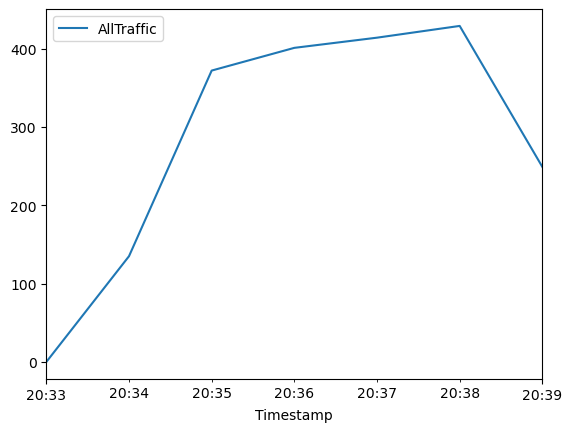

In [7]:
#get-cloudwatch-metrics
def get_invocation_metrics_for_endpoint_variant(endpoint_name, variant_name, start_time, end_time, namespace, metric_name, statistics):
    metrics = cw.get_metric_statistics(
        Namespace=namespace,
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistics],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={statistics: variant_name})
    )

def plot_endpoint_metrics(namespace, metric_name, statistic, start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant_name, start_time, end_time, namespace, metric_name, statistic
    )
    metrics.plot()
    return metrics

print("Waiting a minute for initial metric creation...")
time.sleep(60)
invocations = plot_endpoint_metrics("AWS/SageMaker", "Invocations", "Sum")

To track CPU utilization levels of the instances during the inference requests, query the CPU utilization from CloudWatch.

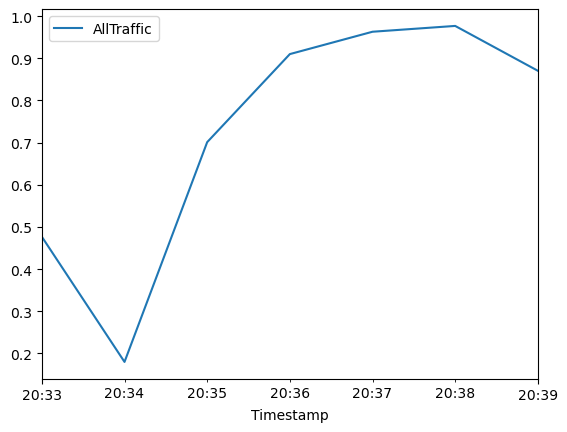

In [8]:
#graph-cpu-utilization
cpu_utilization = plot_endpoint_metrics("/aws/sagemaker/Endpoints", "CPUUtilization", "Average")

Plot graphs to show the Invocation4XXErrors, Invocation5XXErrors, ModelLatency, and OverheadLatency for the endpoint that you created.

Invocation4XXErrors and Invocation5XXErrors should have a flat line because you are using the correct model version and configuration. Invocation errors occur when your inference jobs have any issues.

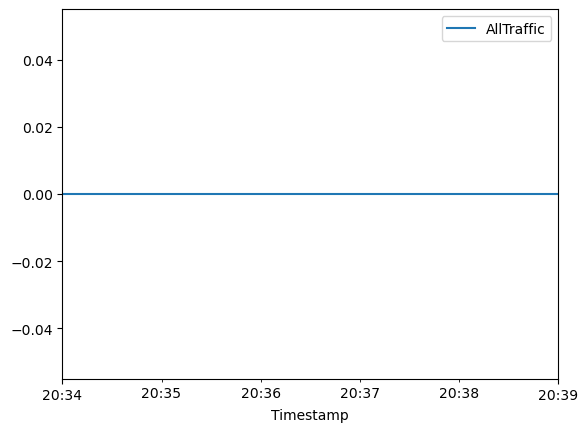

In [9]:
#graph-invocation4xxerrors
invocation_4xx_metrics = plot_endpoint_metrics("AWS/SageMaker", "Invocation4XXErrors", "Sum")

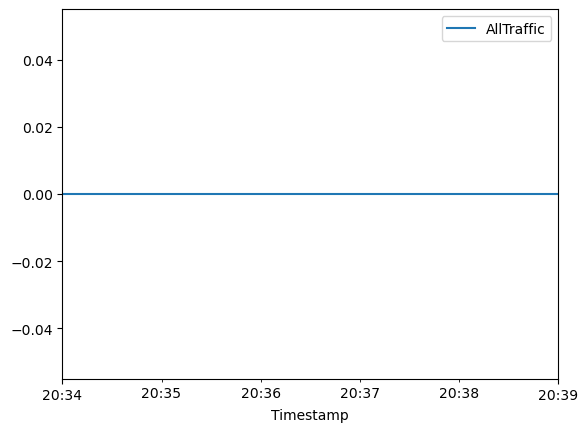

In [10]:
#graph-invocation5xxerrors
invocation_5xx_metrics = plot_endpoint_metrics( "AWS/SageMaker", "Invocation5XXErrors", "Sum")

Additionally, ModelLatency and OverheadLatency start decreasing over time. Model latency is the time that it takes your model to process a unit of data. This duration includes the local communication time for the model to send the request and fetch the response. It also includes the completion time of the inference inside the model container. Overhead latency is the amount of time that SageMaker takes to respond to an invocation request with overheads. This measurement lasts from when SageMaker receives a request until it returns a response, minus model latency. 

Multiple factors might contribute to latency. These factors include the payload size for request and responses, request frequency, and the authentication or authorization of the request. The first invocation for an endpoint might have an increase in latency because of a cold start. This result is expected with the first invocation requests. Over time, your average model latency and overhead latency should slowly drop until they even out.

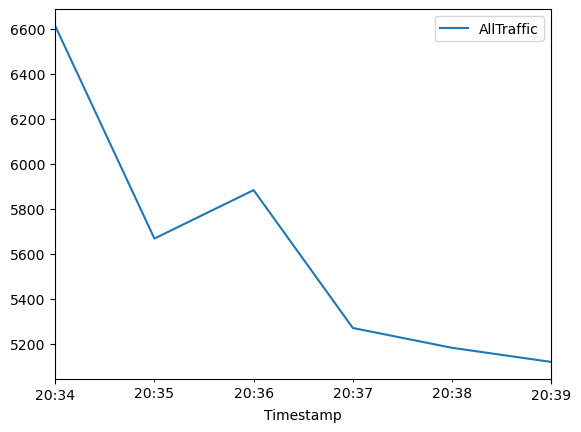

In [11]:
#graph-model-latency
model_latency_metrics = plot_endpoint_metrics("AWS/SageMaker", "ModelLatency", "Average")

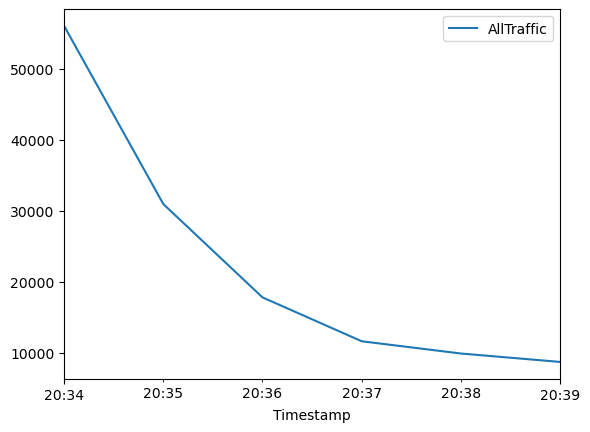

In [12]:
#graph-overhead-latency
overhead_latency_metrics = plot_endpoint_metrics("AWS/SageMaker", "OverheadLatency", "Average")

## Task 2.4: Create a CloudWatch alarm

When you create a traffic routing configuration, the traffic routing job needs to monitor how the routing is going. To monitor the job, you must create a CloudWatch alarm and configure the traffic routing job to include the CloudWatch alarm. A CloudWatch alarm monitors a specific metric and evaluates it based on the configurations that you set. If the alarm changes state, it can invoke an action. Define a function to create a CloudWatch alarm based on a given *alarm_name*, *endpoint_name*, *variant_name*, *metric_name*, *statistic*, and *threshold*.

In [13]:
#define-alarm-function
def create_auto_rollback_alarm(alarm_name, endpoint_name, variant_name, metric_name, statistic, threshold):
    cw.put_metric_alarm(
        AlarmName=alarm_name,
        AlarmDescription="Test SageMaker endpoint deployment auto-rollback alarm",
        ActionsEnabled=False,
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        Statistic=statistic,
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
        Period=60,
        EvaluationPeriods=1,
        Threshold=threshold,
        ComparisonOperator="GreaterThanOrEqualToThreshold",
        TreatMissingData="notBreaching",
    )

For this lab, if invocation errors or high model latency occurs, you want the deployment to roll back. Create alarms that monitor **Invocation5XXErrors** and **ModelLatency**.

In [14]:
#create-alarms
error_alarm = f"TestAlarm-5XXErrors-{endpoint_name}"
latency_alarm = f"TestAlarm-ModelLatency-{endpoint_name}"

# alarm on 1% 5xx error rate for 1 minute
create_auto_rollback_alarm(error_alarm, endpoint_name, "AllTraffic", "Invocation5XXErrors", "Average", 0.2)

# alarm on model latency >= 10 ms for 1 minute
create_auto_rollback_alarm(latency_alarm, endpoint_name, "AllTraffic", "ModelLatency", "Average", 10000)

View the alarms that you just created.

In [15]:
cw.describe_alarms(AlarmNames=[error_alarm, latency_alarm])

{'CompositeAlarms': [],
 'MetricAlarms': [{'AlarmName': 'TestAlarm-5XXErrors-Abalone-2025-06-18-20-30-17',
   'AlarmArn': 'arn:aws:cloudwatch:us-west-2:486956700583:alarm:TestAlarm-5XXErrors-Abalone-2025-06-18-20-30-17',
   'AlarmDescription': 'Test SageMaker endpoint deployment auto-rollback alarm',
   'AlarmConfigurationUpdatedTimestamp': datetime.datetime(2025, 6, 18, 20, 40, 36, 484000, tzinfo=tzlocal()),
   'ActionsEnabled': False,
   'OKActions': [],
   'AlarmActions': [],
   'InsufficientDataActions': [],
   'StateValue': 'INSUFFICIENT_DATA',
   'StateReason': 'Unchecked: Initial alarm creation',
   'StateUpdatedTimestamp': datetime.datetime(2025, 6, 18, 20, 40, 36, 484000, tzinfo=tzlocal()),
   'MetricName': 'Invocation5XXErrors',
   'Namespace': 'AWS/SageMaker',
   'Statistic': 'Average',
   'Dimensions': [{'Name': 'EndpointName',
     'Value': 'Abalone-2025-06-18-20-30-17'},
    {'Name': 'VariantName', 'Value': 'AllTraffic'}],
   'Period': 60,
   'EvaluationPeriods': 1,
   'T

## Task 2.5: Update the endpoint with the traffic routing configuration

Your endpoint is active and you tested the endpoint with a new set of data. To start shifting traffic from one model to another, create a linear policy for the endpoint and update the endpoint. 

In this task, you update the endpoint by using the *update_endpoint* command. The most important component of the *update_endpoint* command is the *EndpointConfigName*. Earlier in the notebook, you set up three endpoint configurations. The first configuration is for the model that is currently in production. The second configuration is for a model that contains a small error in it. Deploying this model shows how the deployment configuration automatically rolls back models with errors during blue/green deployment. The third configuration is for the new model that the data scientist team just trained.

When you configure linear traffic shifting, you have several options to configure. You configure a *DeploymentConfig* that includes a *BlueGreenUpdatePolicy* with a *TrafficRoutingConfiguration*, a *TerminationWaitInSeconds*, and a *MaximumExecutionTimeoutInSections*. The *DeploymentConfig* also includes an *AutoRollbackConfiguration* that monitors your CloudWatch alarm. 

**Learn more:** Refer to [DeploymentConfig](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DeploymentConfig.html) for more information about creating a linear traffic shifting configuration for an endpoint.

In the next code cell, you update the endpoint to use the model that contains a small error in it. This update simulates the automatic rollback feature of linear traffic shifting.

<i class="fas fa-sticky-note" style="color:#ff6633"></i> **Note:** The endpoint update takes approximately 1-2 minutes to make it to 80/20 deployment between the production model and the model with an error.

In [16]:
#add-linear-traffic-shifting-to-endpoint
response = sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_2_name,
    DeploymentConfig={
        "BlueGreenUpdatePolicy": {
            "TrafficRoutingConfiguration": {
                "Type": "LINEAR",
                "LinearStepSize": {
                    "Type": "CAPACITY_PERCENT",
                    "Value": 20
                },
                "WaitIntervalInSeconds": 60
            },
            "TerminationWaitInSeconds": 120,
            "MaximumExecutionTimeoutInSeconds": 1200
        },
        "AutoRollbackConfiguration": {
            "Alarms": [
                {
                    "AlarmName": error_alarm
                },
                {
                    "AlarmName": latency_alarm
                }
            ]
        }
    }
)

time.sleep(60)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

EndpointArn = arn:aws:sagemaker:us-west-2:486956700583:endpoint/Abalone-2025-06-18-20-30-17


Describe the endpoint. While the traffic shifts from one model to another, the *EndpointStatus* is *Updating*. If the linear traffic shifting job is successful, the *EndpointStatus* eventually changes to *InService*. You do not need to wait for the traffic shifting to complete before moving on to the next task.

In [17]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'Abalone-2025-06-18-20-30-17',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:486956700583:endpoint/Abalone-2025-06-18-20-30-17',
 'EndpointConfigName': 'Abalone-Endpoint-1-2025-06-18-20-30-15',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.5-1',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:cd128bd02824075bf2e02ee7923aaa8ab50f6c47a2d86d5747b78ca1c5199813',
     'ResolutionTime': datetime.datetime(2025, 6, 18, 20, 30, 18, 764000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 4,
   'DesiredInstanceCount': 4}],
 'EndpointStatus': 'Updating',
 'CreationTime': datetime.datetime(2025, 6, 18, 20, 30, 18, 18000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 6, 18, 20, 40, 37, 612000, tzinfo=tzlocal()),
 'LastDeploymentConfig': {'BlueGreenUpdatePolicy

The production model *ProductionVariants* is configured with a variant name of *AllTraffic* and a *SpecifiedImage* that contains *sagemaker-xgboost:1.5-1*. The new model variant information is contained in the *PendingDeploymentSummary*. In the *PendingDeploymentSummary*, notice that *SpecifiedImage* is using *sagemaker-xgboost:1.2-1*. This version causes an error with your model. In this endpoint, all of the traffic is configured to shift from the production model to the model with a small error in it.

## Task 2.6: View the fleet deployment and monitor for failures

Send test data to the endpoint. If any errors appear, this function prints an **E** instead of a period.

In [18]:
#send-test-data
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

error_count = 0
for i in range(0,3):
    with open("data/abalone_data_test.csv", "r") as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip("\n")
            try:
                response = sm_runtime.invoke_endpoint(
                    EndpointName=endpoint_name, ContentType="text/csv", Body=payload
                )
                response["Body"].read()
                print(".", end="", flush=True)
            except Exception as e:
                print("E", end="", flush=True)
                error_count += 1
                if error_count >= 5:
                    break
            time.sleep(0.5)
f.close()
print("Done!")

Sending test traffic to the endpoint Abalone-2025-06-18-20-30-17. 
Please wait...
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................E.E.....................E...E.........E...............E.............EDone!


If no errors printed as E in the prior cell, wait one minute and run the cell again. Continue running the cell until you see the errors appear.

Several errors were thrown during invocation. Wait for the update operation to complete and verify the automatic rollback.

<i class="fas fa-sticky-note" style="color:#ff6633"></i> **Note:** The endpoint update takes approximately 1–4 minutes to complete.

In [19]:
#wait-for-the-endpoint-to-update
def wait_for_endpoint_update_complete(endpoint):
    """Helper function to wait for the completion of updating an endpoint"""
    response = sm.describe_endpoint(EndpointName=endpoint_name)
    status = response.get("EndpointStatus")
    while status == "Updating":
        print("Waiting for Endpoint to Update")
        time.sleep(15)
        response = sm.describe_endpoint(EndpointName=endpoint_name)
        status = response.get("EndpointStatus")
        # print(response)

    if status != "InService":
        print(f"Failed to update endpoint, response: {response}")
        failureReason = response.get("FailureReason", "")
        raise SystemExit(
            f"Failed to update endpoint {endpoint_response['EndpointArn']}, status: {status}, reason: {failureReason}"
        )
    print(f"Endpoint {endpoint_response['EndpointArn']} successfully updated.")

wait_for_endpoint_update_complete(endpoint=endpoint_response)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Endpoint arn:aws:sagemaker:us-west-2:486956700583:endpoint/Abalone-2025-06-18-20-30-17 successfully updated.


{'EndpointName': 'Abalone-2025-06-18-20-30-17',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:486956700583:endpoint/Abalone-2025-06-18-20-30-17',
 'EndpointConfigName': 'Abalone-Endpoint-1-2025-06-18-20-30-15',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.5-1',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:cd128bd02824075bf2e02ee7923aaa8ab50f6c47a2d86d5747b78ca1c5199813',
     'ResolutionTime': datetime.datetime(2025, 6, 18, 20, 30, 18, 764000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 4,
   'DesiredInstanceCount': 4}],
 'EndpointStatus': 'InService',
 'FailureReason': 'One or more configured alarm for automatic rollback deployment is in ALARM state: [TestAlarm-ModelLatency-Abalone-2025-06-18-20-30-17].',
 'CreationTime': datetime.datetime(2025, 6, 18, 20, 30, 18, 18000, 

The production model *ProductionVariants* is configured with a variant name of *AllTraffic* and a *SpecifiedImage* that contains *sagemaker-xgboost:1.5-1*. The *PendingDeploymentSummary* that included the model with an error is gone now.

Plot graphs to show the Invocations, Invocation5XXErrors, and ModelLatency for the endpoint that you created.

As the new model started deploying, it encountered errors and rolled back. The errors can be seen in the graphs as the Invocation5XXErrors and ModelLatency metrics increase.

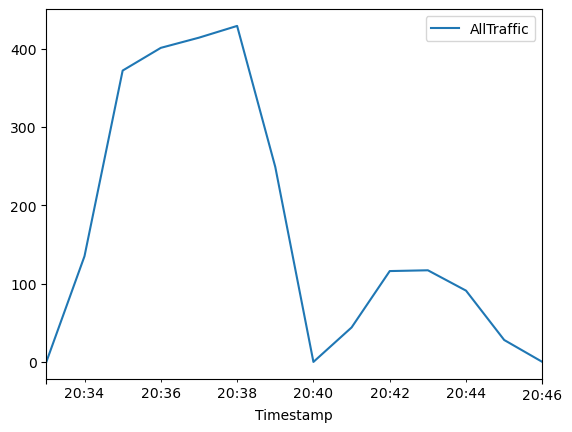

In [20]:
#graph-invocations
invocations = plot_endpoint_metrics("AWS/SageMaker", "Invocations", "Sum")

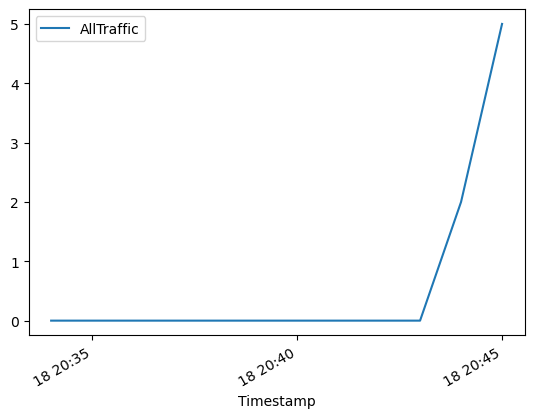

In [21]:
#graph-invocation5xxerrors
invocation_5xx_metrics = plot_endpoint_metrics( "AWS/SageMaker", "Invocation5XXErrors", "Sum")

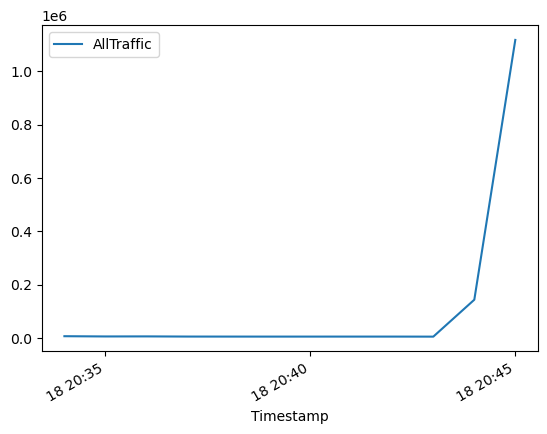

In [22]:
#graph-model-latency
model_latency_metrics = plot_endpoint_metrics("AWS/SageMaker", "ModelLatency", "Average")

The model failed and rolled back. In the next task, you update the endpoint to use the new model that you tested in the prior lab.

## Task 2.7: Update the endpoint with a new traffic routing configuration

When a linear traffic shifting job rolls back, you can update the traffic configuration to restart the linear traffic shifting with a new configuration. 

In [23]:
#update-endpoint-retain-deployment-config
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_3_name,
    RetainDeploymentConfig=True,
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:486956700583:endpoint/Abalone-2025-06-18-20-30-17',
 'ResponseMetadata': {'RequestId': '2ff57480-a711-4559-bfde-cdcdaa0994ea',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2ff57480-a711-4559-bfde-cdcdaa0994ea',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '95',
   'date': 'Wed, 18 Jun 2025 20:48:17 GMT'},
  'RetryAttempts': 0}}

Describe the endpoint. While the traffic shifts from one model to another, the *EndpointStatus* is *Updating*. 

In [24]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'Abalone-2025-06-18-20-30-17',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:486956700583:endpoint/Abalone-2025-06-18-20-30-17',
 'EndpointConfigName': 'Abalone-Endpoint-1-2025-06-18-20-30-15',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.5-1',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:cd128bd02824075bf2e02ee7923aaa8ab50f6c47a2d86d5747b78ca1c5199813',
     'ResolutionTime': datetime.datetime(2025, 6, 18, 20, 30, 18, 764000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 4,
   'DesiredInstanceCount': 4}],
 'EndpointStatus': 'Updating',
 'FailureReason': 'One or more configured alarm for automatic rollback deployment is in ALARM state: [TestAlarm-ModelLatency-Abalone-2025-06-18-20-30-17].',
 'CreationTime': datetime.datetime(2025, 6, 18, 20, 30, 18, 18000, t

The production model *ProductionVariants* is configured with a variant name of *AllTraffic* and a *SpecifiedImage* that contains *sagemaker-xgboost:1.5-1*. The new model variant information is contained in the *PendingDeploymentSummary*. In the *PendingDeploymentSummary*, notice that *SpecifiedImage* is also using *sagemaker-xgboost:1.5-1*. In this endpoint, all traffic is configured to shift from the production model to the new model.

Invoke the endpoint while the model updates. Because the endpoint deployment rolled back to the production model and you already tested the new model, you should see no errors. 

In [25]:
#send-test-data
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

error_count = 0
with open("data/abalone_data_test.csv", "r") as f:
    for row in f:
        payload = row.rstrip("\n")
        try:
            response = sm_runtime.invoke_endpoint(
                EndpointName=endpoint_name, ContentType="text/csv", Body=payload
            )
            response["Body"].read()
            print(".", end="", flush=True)
        except Exception as e:
            print("E", end="", flush=True)
            error_count += 1
            if error_count == 5:
                break
        time.sleep(0.1)
f.close()
print("Done!")

Sending test traffic to the endpoint Abalone-2025-06-18-20-30-17. 
Please wait...
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Collect the endpoint metrics during the deployment.

The traffic is actively shifting from the production model to the new model. As the linear traffic shifting job runs, the Invocation5XXErrors show no issues and the average ModelLatency decreases.

Waiting a minute for metric creation...


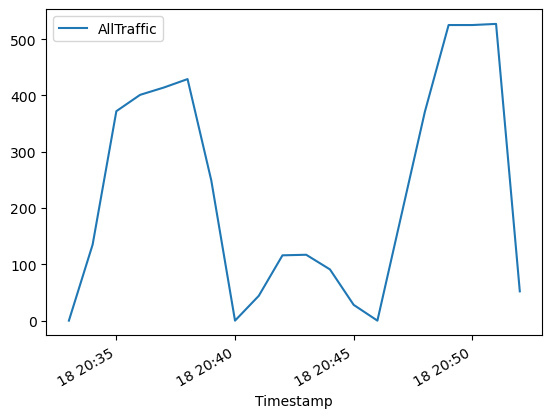

In [26]:
#graph-invocations
print("Waiting a minute for metric creation...")
time.sleep(60)
invocations = plot_endpoint_metrics("AWS/SageMaker", "Invocations", "Sum")

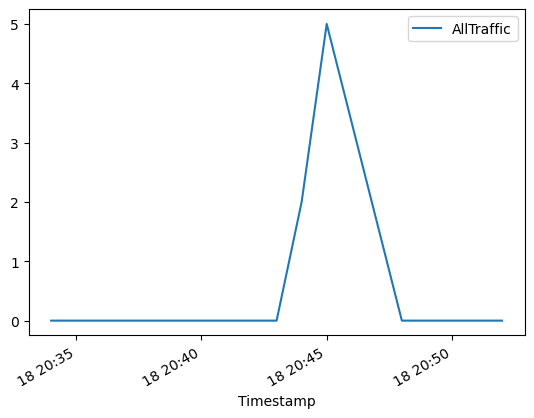

In [27]:
#graph-invocation5xxerrors
invocation_5xx_metrics = plot_endpoint_metrics( "AWS/SageMaker", "Invocation5XXErrors", "Sum")

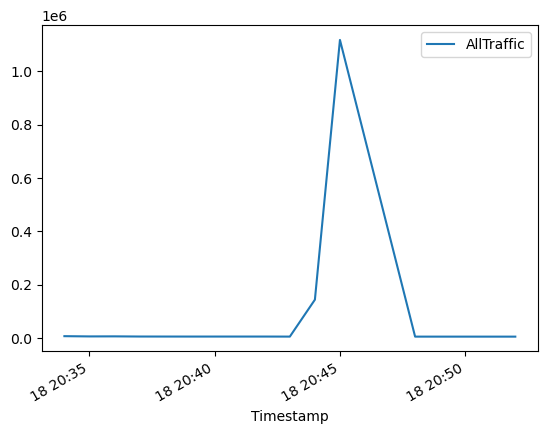

In [28]:
#graph-model-latency
model_latency_metrics = plot_endpoint_metrics("AWS/SageMaker", "ModelLatency", "Average")

You have conducted linear traffic shifting to gradually shift traffic from your old model to a model with an error, which automatically rolled back. Then, you successfully shifted traffic from your old model to your new model.

### Cleanup

You have completed this notebook. To move to the next part of the lab, do the following:

- Close this notebook file.
- Return to the lab session and continue with the **Conclusion**.